In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [3]:
!pip install datasets evaluate transformers
!pip install accelerate -U
!pip install transformers[torch]

In [4]:
!pip install accelerate --upgrade

In [5]:
import numpy as np
import pandas as pd
import os

from datasets import load_dataset, DatasetDict

import evaluate

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)

import matplotlib.pyplot as plt

In [6]:
INPUT_DIR = "./"
OUTPUT_DIR = "./output/bert"
CHECKPOINT = "google-bert/bert-base-multilingual-uncased"

In [7]:
# Load data
data = load_dataset("csv", data_files=os.path.join(INPUT_DIR, "train.csv"), trust_remote_code=True, split="train")
data = data.train_test_split(0.2)

data = DatasetDict(
    {
        "train": data["train"],
        "val": data["test"],
        "test": load_dataset("csv", data_files=os.path.join(INPUT_DIR, "test.csv"), trust_remote_code=True, split="train"),
    }
)
data

DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 9696
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 2424
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language'],
        num_rows: 5195
    })
})

In [32]:
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT, truncation=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=3)
model

import torch
import torch.nn as nn

class CNNCls(nn.Module):
    def __init__(self):
        super(CNNCls, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=256, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)
        x = x.mean(dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

class LSTMCls(nn.Module):
    def __init__(self):
        super(LSTMCls, self).__init__()
        self.lstm = nn.LSTM(input_size=768, hidden_size=256, num_layers=1, batch_first=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        # LSTM返回两个元组，(output, (h_n, c_n))
        # output: (batch_size, seq_length, num_directions * hidden_size)
        # h_n: (num_layers * num_directions, batch_size, hidden_size)
        # c_n: (num_layers * num_directions, batch_size, hidden_size)
        output, (h_n, c_n) = self.lstm(x)
        x = self.relu(output)  # 取序列的最后一个输出
        x = self.dropout(x)
        x = self.fc(x)
        return x

class GRUCls(nn.Module):
    def __init__(self):
        super(GRUCls, self).__init__()
        self.gru = nn.GRU(input_size=768, hidden_size=256, num_layers=1, batch_first=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        # GRU的输出 (output, h_n)
        output, h_n = self.gru(x)  # output: (batch_size, seq_length, hidden_size)
        x = self.relu(output)  # 取序列的最后一个输出
        x = self.dropout(x)
        x = self.fc(x)
        return x

class RNNCls(nn.Module):
    def __init__(self):
        super(RNNCls, self).__init__()
        self.rnn = nn.RNN(input_size=768, hidden_size=256, num_layers=1, batch_first=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        # RNN的输出包括 (output, h_n)
        output, h_n = self.rnn(x)  # output: (batch_size, seq_length, hidden_size)
        x = self.relu(output)  # 取序列的最后一个输出
        x = self.dropout(x)
        x = self.fc(x)
        return x

class MultiheadAttentionCls(nn.Module):
    def __init__(self):
        super(MultiheadAttentionCls, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(768, 3)

    def forward(self, x):
        # 假设x的形状是(batch_size, seq_length, embed_dim)
        # 多头注意力需要输入key, query, value，这里我们使用同一个x作为三者
        attn_output, _ = self.attention(x, x, x)
        # 取多头注意力输出的平均或者最后一个时间步的输出
        x = self.relu(attn_output)
        x = self.dropout(x)
        x = self.fc(x)
        return x

model.classifier = MultiheadAttentionCls()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
def preprocess_data(batch):
    batch["text"] = [
        x1 + f" {tokenizer.sep_token} " + x2
        for x1, x2 in zip(batch["premise"], batch["hypothesis"])
    ]
    return tokenizer(batch["text"])

data = data.map(preprocess_data, batched=True)

Map:   0%|          | 0/9696 [00:00<?, ? examples/s]

Map:   0%|          | 0/2424 [00:00<?, ? examples/s]

Map:   0%|          | 0/5195 [00:00<?, ? examples/s]

In [34]:
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    return metric.compute(predictions=preds, references=labels)


train_args = TrainingArguments(
    output_dir=os.path.join(OUTPUT_DIR, "results"),
    logging_dir=os.path.join(OUTPUT_DIR, "logs"),
    report_to=[],
    evaluation_strategy="steps",
    eval_steps=200,
    logging_steps=200,
    save_steps=200,
    per_device_eval_batch_size=16,
    per_device_train_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.005,
    num_train_epochs=5,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=3,
    save_only_model=True,
)

In [35]:
trainer = Trainer(
    model=model,
    args=train_args,
    data_collator=data_collator,
    train_dataset=data["train"],
    eval_dataset=data["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(3)],
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy
200,1.102600,1.090999,0.397277
400,1.017800,0.940900,0.556518
600,0.914400,0.882257,0.588284
800,0.809400,0.876744,0.605611
1000,0.778000,0.880911,0.606436
1200,0.790200,0.845107,0.614686
1400,0.600600,0.944735,0.617162
1600,0.586800,0.937149,0.625825
1800,0.601600,0.912777,0.625413
2000,0.439000,1.025228,0.627063


TrainOutput(global_step=2800, training_loss=0.6589658519199916, metrics={'train_runtime': 437.2265, 'train_samples_per_second': 110.881, 'train_steps_per_second': 6.93, 'total_flos': 2091874324940352.0, 'train_loss': 0.6589658519199916, 'epoch': 4.62046204620462})

In [36]:
log = trainer.state.log_history

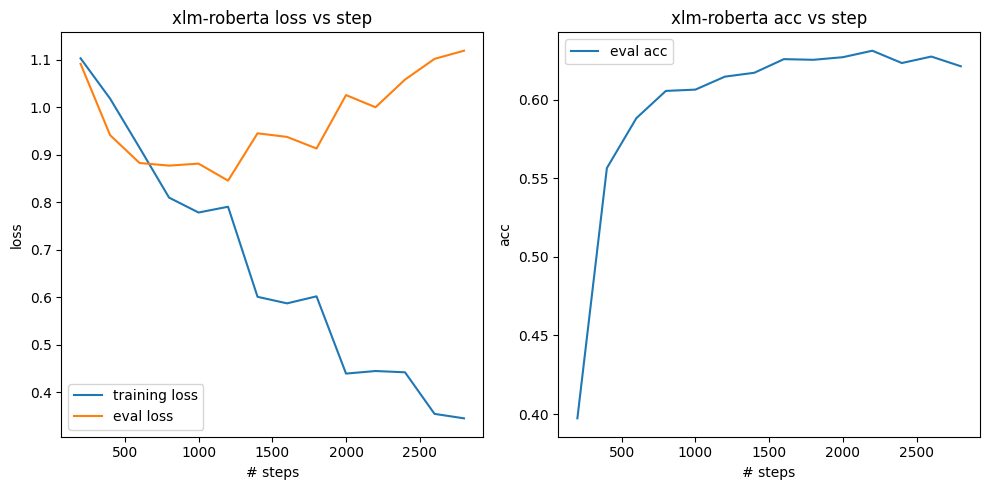

In [37]:
steps = []
train_loss = []
eval_loss = []
eval_acc = []

for i in range(0, len(log) - 1, 2):
    train_log = log[i]
    eval_log = log[i + 1]
    steps.append(train_log["step"])
    train_loss.append(train_log["loss"])
    eval_loss.append(eval_log["eval_loss"])
    eval_acc.append(eval_log["eval_accuracy"])

plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.title("xlm-roberta loss vs step")
plt.xlabel("# steps")
plt.ylabel("loss")
plt.plot(steps, train_loss, label="training loss")
plt.plot(steps, eval_loss, label="eval loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("xlm-roberta acc vs step")
plt.xlabel("# steps")
plt.ylabel("acc")
plt.plot(steps, eval_acc, label="eval acc")
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
preds = trainer.predict(data["test"])

In [39]:
pd.DataFrame(
    {"id": data["test"]["id"], "prediction": np.argmax(preds.predictions, axis=1)}
).to_csv(os.path.join(OUTPUT_DIR, "submission.csv"), header=True, index=False)